In [1]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from pixellib.tune_bg import alter_bg
from matplotlib import pyplot as plt

## Step 1. 스티커 구하기 or 만들기

## Step 2. 얼굴 검출 & 랜드마크 검출 하기
---
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾기

In [61]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

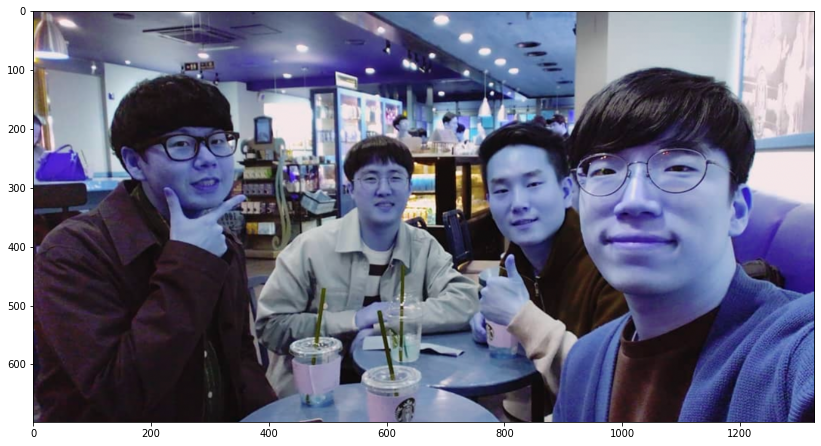

In [62]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png' # lee 이미지의 경로


img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다

# 이미지 경로 실패시 확인 코드 추가
if img_bgr is None:
    print("이미지를 불러오지 못했습니다. 경로를 확인해주세요.")
else:
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

plt.figure(figsize=(14, 10))  # 이미지 출력 크기 조정
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

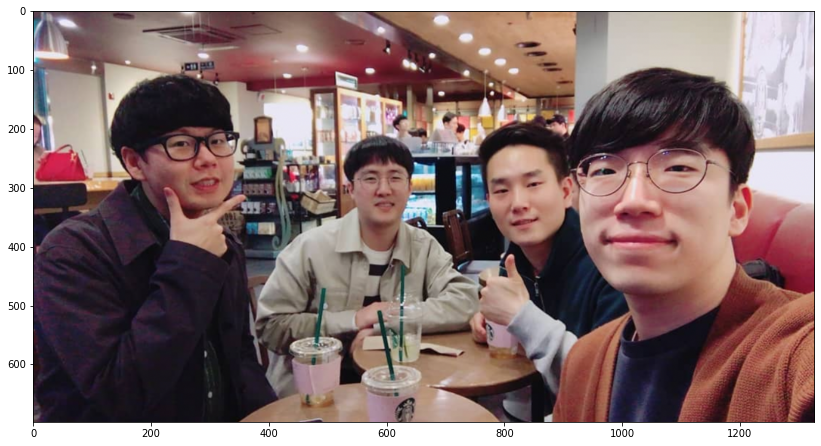

In [63]:
# plt.imshow 이전에 RGB 이미지로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10))  # 이미지 출력 크기 조정
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 
plt.show() # 이미지 실제 출력

In [64]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [65]:
height, width = 500, 500  # 원하는 크기 설정
img_rgb = np.zeros((height, width, 3), dtype=np.uint8)  # RGB 3채널 초기화

In [66]:
# detector_hog를 이용해서 얼굴의 bounding box를 추출

img_rgb = cv2.cvtColor(img_bgr.copy(), cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(755, 254) (884, 383)], [(554, 255) (643, 345)], [(884, 201) (1152, 468)], [(225, 196) (354, 325)]]


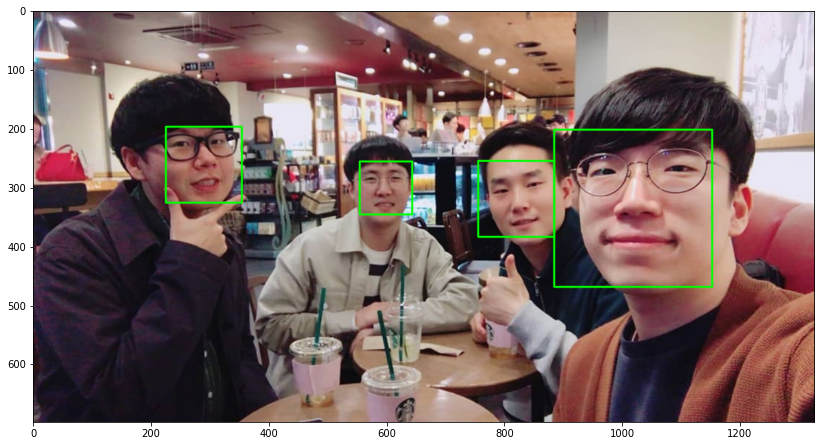

In [67]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10))  # 이미지 출력 크기 조정
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크 face landmark
- Dlib의 제공되는 모델을 사용 
- 공개되어 있는 weight file을 다운로드
- 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용


In [68]:
# ! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# ! mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
# ! cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [69]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [70]:
# 랜드마크의 위치를 저장할 list 생성    
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장    
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmarks에 랜드마크 리스트를 저장    
    list_landmarks.append(list_points)
        
# 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
# 각 원소는 68개의 랜드마크 위치가 나열된 list 
# list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생
print(len(list_landmarks[0]))

68


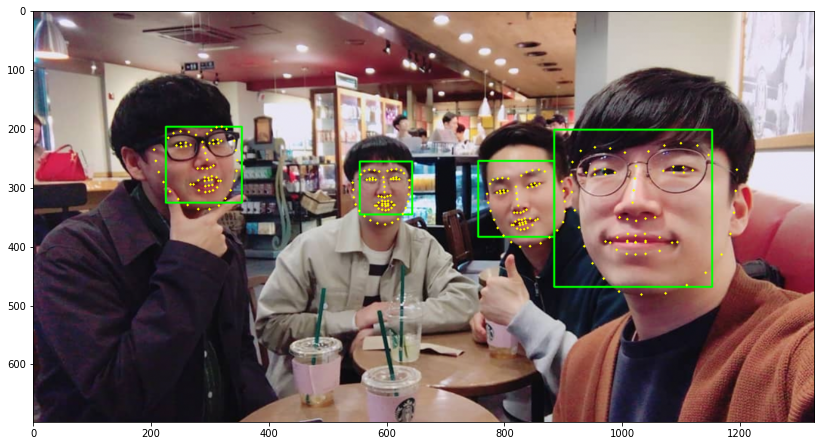

In [71]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

            # RGB 이미지로 전환
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 10))  # 이미지 출력 크기 조정
# 이미지를 준비
plt.imshow(img_show_rgb)
# 이미지를 출력
plt.show()

## Step 3. 스티커 적용 위치 확인하기
---
스티커가 적용 될 위치를 landmark를 사용해서 계산
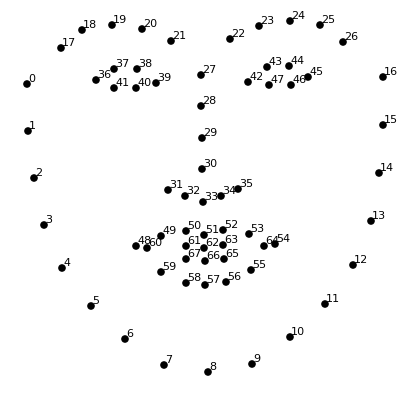

In [72]:
# 수염 스티커 path 설정
whisker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/king2.png'
whisker_img = cv2.imread(whisker_path, cv2.IMREAD_UNCHANGED)

# 이미지 로드 실패 확인
if whisker_img is None:
    raise FileNotFoundError(f"이미지를 로드할 수 없습니다: {whisker_img_path}")
    
    
# 채널 수 확인
if whisker_img.shape[-1] == 4:  # 알파 채널이 있는 경우
    whisker_alpha = whisker_img[:, :, 3] / 255.0  # 알파 채널 분리
    whisker_rgb = whisker_img[:, :, :3]           # RGB 채널 분리
elif whisker_img.shape[-1] == 3:  # RGB 이미지인 경우
    whisker_alpha = np.ones(whisker_img.shape[:2], dtype=np.float32)  # 알파 채널을 기본값(1.0)으로 설정
    whisker_rgb = whisker_img  # RGB 채널 그대로 사용
else:
    raise ValueError("지원하지 않는 이미지 형식입니다. RGBA 또는 RGB 이미지를 사용하세요.")

# 출력 확인
print(f"RGB 채널 크기: {whisker_rgb.shape}")
print(f"알파 채널 크기: {whisker_alpha.shape}")    

RGB 채널 크기: (512, 512, 3)
알파 채널 크기: (512, 512)


In [73]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(823, 330)
(x,y) : (823,265)
(w,h) : (130,130)
(596, 307)
(x,y) : (596,262)
(w,h) : (90,90)
(1017, 325)
(x,y) : (1017,191)
(w,h) : (269,269)
(295, 252)
(x,y) : (295,187)
(w,h) : (130,130)


In [74]:

img_sticker = cv2.imread(whisker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (180,180)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수 // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(180, 180, 3)


In [75]:
import cv2
import numpy as np

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 왕관 크기 설정: 너비는 바운딩 박스 너비와 동일, 높이는 너비의 절반
    crown_width = dlib_rect.width()
    crown_height = crown_width // 2

    # 왕관의 중심 좌표 계산 (왕관의 하단이 바운딩 박스 상단에서 10픽셀 위로 설정)
    crown_x = (dlib_rect.left() + dlib_rect.right()) // 2  # 얼굴 바운딩 박스의 중앙 x좌표
    crown_y = dlib_rect.top() - 10 - (crown_height // 2)  # 하단을 기준으로 중심 계산

    # 왕관 스티커 이미지 크기 조정
    crown_img = cv2.resize(whisker_img, (crown_width, crown_height))  # whisker_img를 왕관으로 사용

    # 왕관 적용 영역(ROI) 설정
    x1, y1 = crown_x - crown_width // 2, crown_y - crown_height // 2
    x2, y2 = x1 + crown_width, y1 + crown_height

    # 이미지 경계 내에 ROI가 있는지 확인
    if x1 >= 0 and y1 >= 0 and x2 <= img_show.shape[1] and y2 <= img_show.shape[0]:
        # 왕관 스티커의 알파 채널 분리
        crown_alpha = crown_img[:, :, 3] / 255.0  # 0~255를 0~1 범위로 변환
        crown_rgb = crown_img[:, :, :3]  # RGB 채널만 분리

        # ROI 영역에 왕관 스티커 적용
        roi = img_show[y1:y2, x1:x2]
        for c in range(3):  # B, G, R 채널별로 합성
            roi[:, :, c] = (1.0 - crown_alpha) * roi[:, :, c] + crown_alpha * crown_rgb[:, :, c]

        # 결과를 원본 이미지에 적용
        img_show[y1:y2, x1:x2] = roi


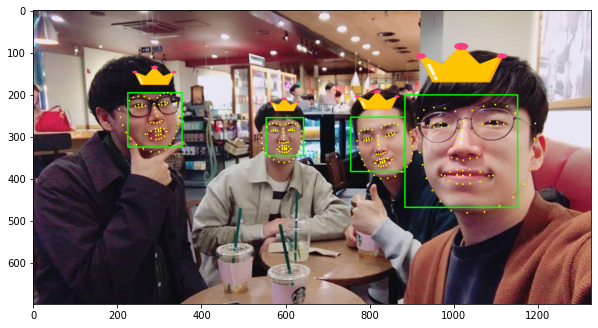

In [76]:
# 이미지 출력
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_show_rgb)
plt.show()

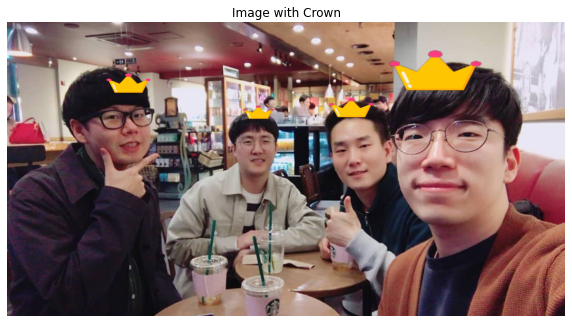

In [77]:
import cv2
import matplotlib.pyplot as plt

def overlay_crown(img_bgr, dlib_rects, list_landmarks, crown_img):
    """
    원본 이미지에 왕관 스티커를 오버레이합니다.
    """
    img_with_crown = img_bgr.copy()  # 원본 이미지를 복사하여 사용

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # 왕관 크기 설정: 바운딩 박스 너비와 동일, 높이는 너비의 절반
        crown_width = dlib_rect.width()
        crown_height = crown_width // 2

        # 왕관의 중심 좌표 계산 (왕관 하단이 바운딩 박스 상단에서 20픽셀 위)
        crown_x = (dlib_rect.left() + dlib_rect.right()) // 2
        crown_y = dlib_rect.top() - 20 - (crown_height // 2)

        # 왕관 스티커 이미지 크기 조정
        resized_crown = cv2.resize(crown_img, (crown_width, crown_height))

        # 왕관 적용 영역(ROI) 설정
        x1 = crown_x - crown_width // 2
        y1 = crown_y - crown_height // 2
        x2 = x1 + crown_width
        y2 = y1 + crown_height

        # 이미지 경계 내에 ROI가 있는지 확인
        if x1 >= 0 and y1 >= 0 and x2 <= img_with_crown.shape[1] and y2 <= img_with_crown.shape[0]:
            # 왕관 스티커의 알파 채널 분리
            crown_alpha = resized_crown[:, :, 3] / 255.0  # 알파 채널(투명도)
            crown_rgb = resized_crown[:, :, :3]  # RGB 채널

            # ROI 영역에 왕관 스티커 적용
            roi = img_with_crown[y1:y2, x1:x2]
            for c in range(3):  # B, G, R 채널별로 합성
                roi[:, :, c] = (1.0 - crown_alpha) * roi[:, :, c] + crown_alpha * crown_rgb[:, :, c]

            # 결과를 원본 이미지에 적용
            img_with_crown[y1:y2, x1:x2] = roi

    return img_with_crown

def display_image(img_with_crown):
    """
    왕관이 오버레이된 이미지를 출력합니다.
    """
    img_with_crown_rgb = cv2.cvtColor(img_with_crown, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    plt.figure(figsize=(10, 10))  # 출력 크기 설정
    plt.title("Image with Crown")
    plt.imshow(img_with_crown_rgb)
    plt.axis("off")  # 축 숨기기
    plt.show()

# Example usage
# img_bgr: 원본 이미지 (BGR 형식)
# dlib_rects: dlib 얼굴 바운딩 박스 리스트
# list_landmarks: 68개 얼굴 랜드마크 좌표 리스트
# crown_img: 왕관 스티커 이미지 (RGBA 형식)

img_with_crown = overlay_crown(img_bgr, dlib_rects, list_landmarks, crown_img)
display_image(img_with_crown)


## SSD 모델

In [1]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [2]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

print('슝=3')

슝=3


In [3]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

print('슝=3')

슝=3


In [4]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

print('슝=3')

슝=3


In [5]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

print('슝=3')

슝=3


In [6]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

In [7]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

print('슝=3')

슝=3


In [8]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:14<00:00, 227.24it/s]


In [9]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


In [10]:
# 사용할 default box 정보를 전역 변수로 만들어 둡니다.

BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

print('슝=3')

슝=3


In [11]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

In [12]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)



18800

In [13]:

#생성된 boxes에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열 시켜줄게요.

pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


In [14]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

print('슝=3')

슝=3


In [15]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

print('슝=3')

슝=3


In [16]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

print('슝=3')

슝=3


In [17]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

print('슝=3')

슝=3


In [18]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

print('슝=3')

슝=3


In [19]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

print('슝=3')

슝=3


In [20]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

print('슝=3')

슝=3


In [21]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

In [22]:
def YourSsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)

    # 입력 이미지 정의
    inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    # 특징 추출 블록
    x = _conv_block(inputs, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    # 추가 계층 (중간 및 깊은 특징 추출)
    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [23]:
model1 = YourSsdModel()
print("the number of model layers: ", len(model.layers))
model1.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
_________________________________________________________

In [24]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

print('슝=3')

슝=3


In [25]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

print('슝=3')

슝=3


In [26]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

print('슝=3')

슝=3


In [27]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

print('슝=3')

슝=3


In [28]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

print('슝=3')

슝=3


In [29]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

print('슝=3')

슝=3


In [30]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

print('슝=3')

슝=3


In [31]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

print('슝=3')

슝=3


In [32]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

print('슝=3')

슝=3


In [33]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

print('슝=3')

슝=3


In [34]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [35]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [36]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

print('슝=3')

슝=3


In [37]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

print('슝=3')

슝=3


## 14-7. 모델 학습(2) train
### Learning rate scheduler
본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 그중 하나는 Learning rate scheduler 입니다. 이번에는 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다. PiecewiseConstantWarmUpDecay정도의 이름으로 만들어 사용할게요.

In [38]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

print('슝=3')

슝=3


In [39]:
# PiecewiseConstantWarmUpDecay를 편하게 사용할 수 있도록 함수를 만들어 둡니다.

def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

print('슝=3')

슝=3


### Hard negative mining

Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [40]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

print('슝=3')

슝=3


In [41]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

print('슝=3')

슝=3


### Training
---

이제 본격적으로 모델 학습을 진행하겠습니다.

Default box를 만들고 데이터셋을 준비합니다.

In [42]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

print('슝=3')

슝=3


Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_29 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_29 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_29[0][0]                
__________________________________________________________________________________________________
conv_bn_29 (BatchNormalization) (None, 128, 160, 16) 64          conv_29[0][0]                    
__________________________________________________________________________________________

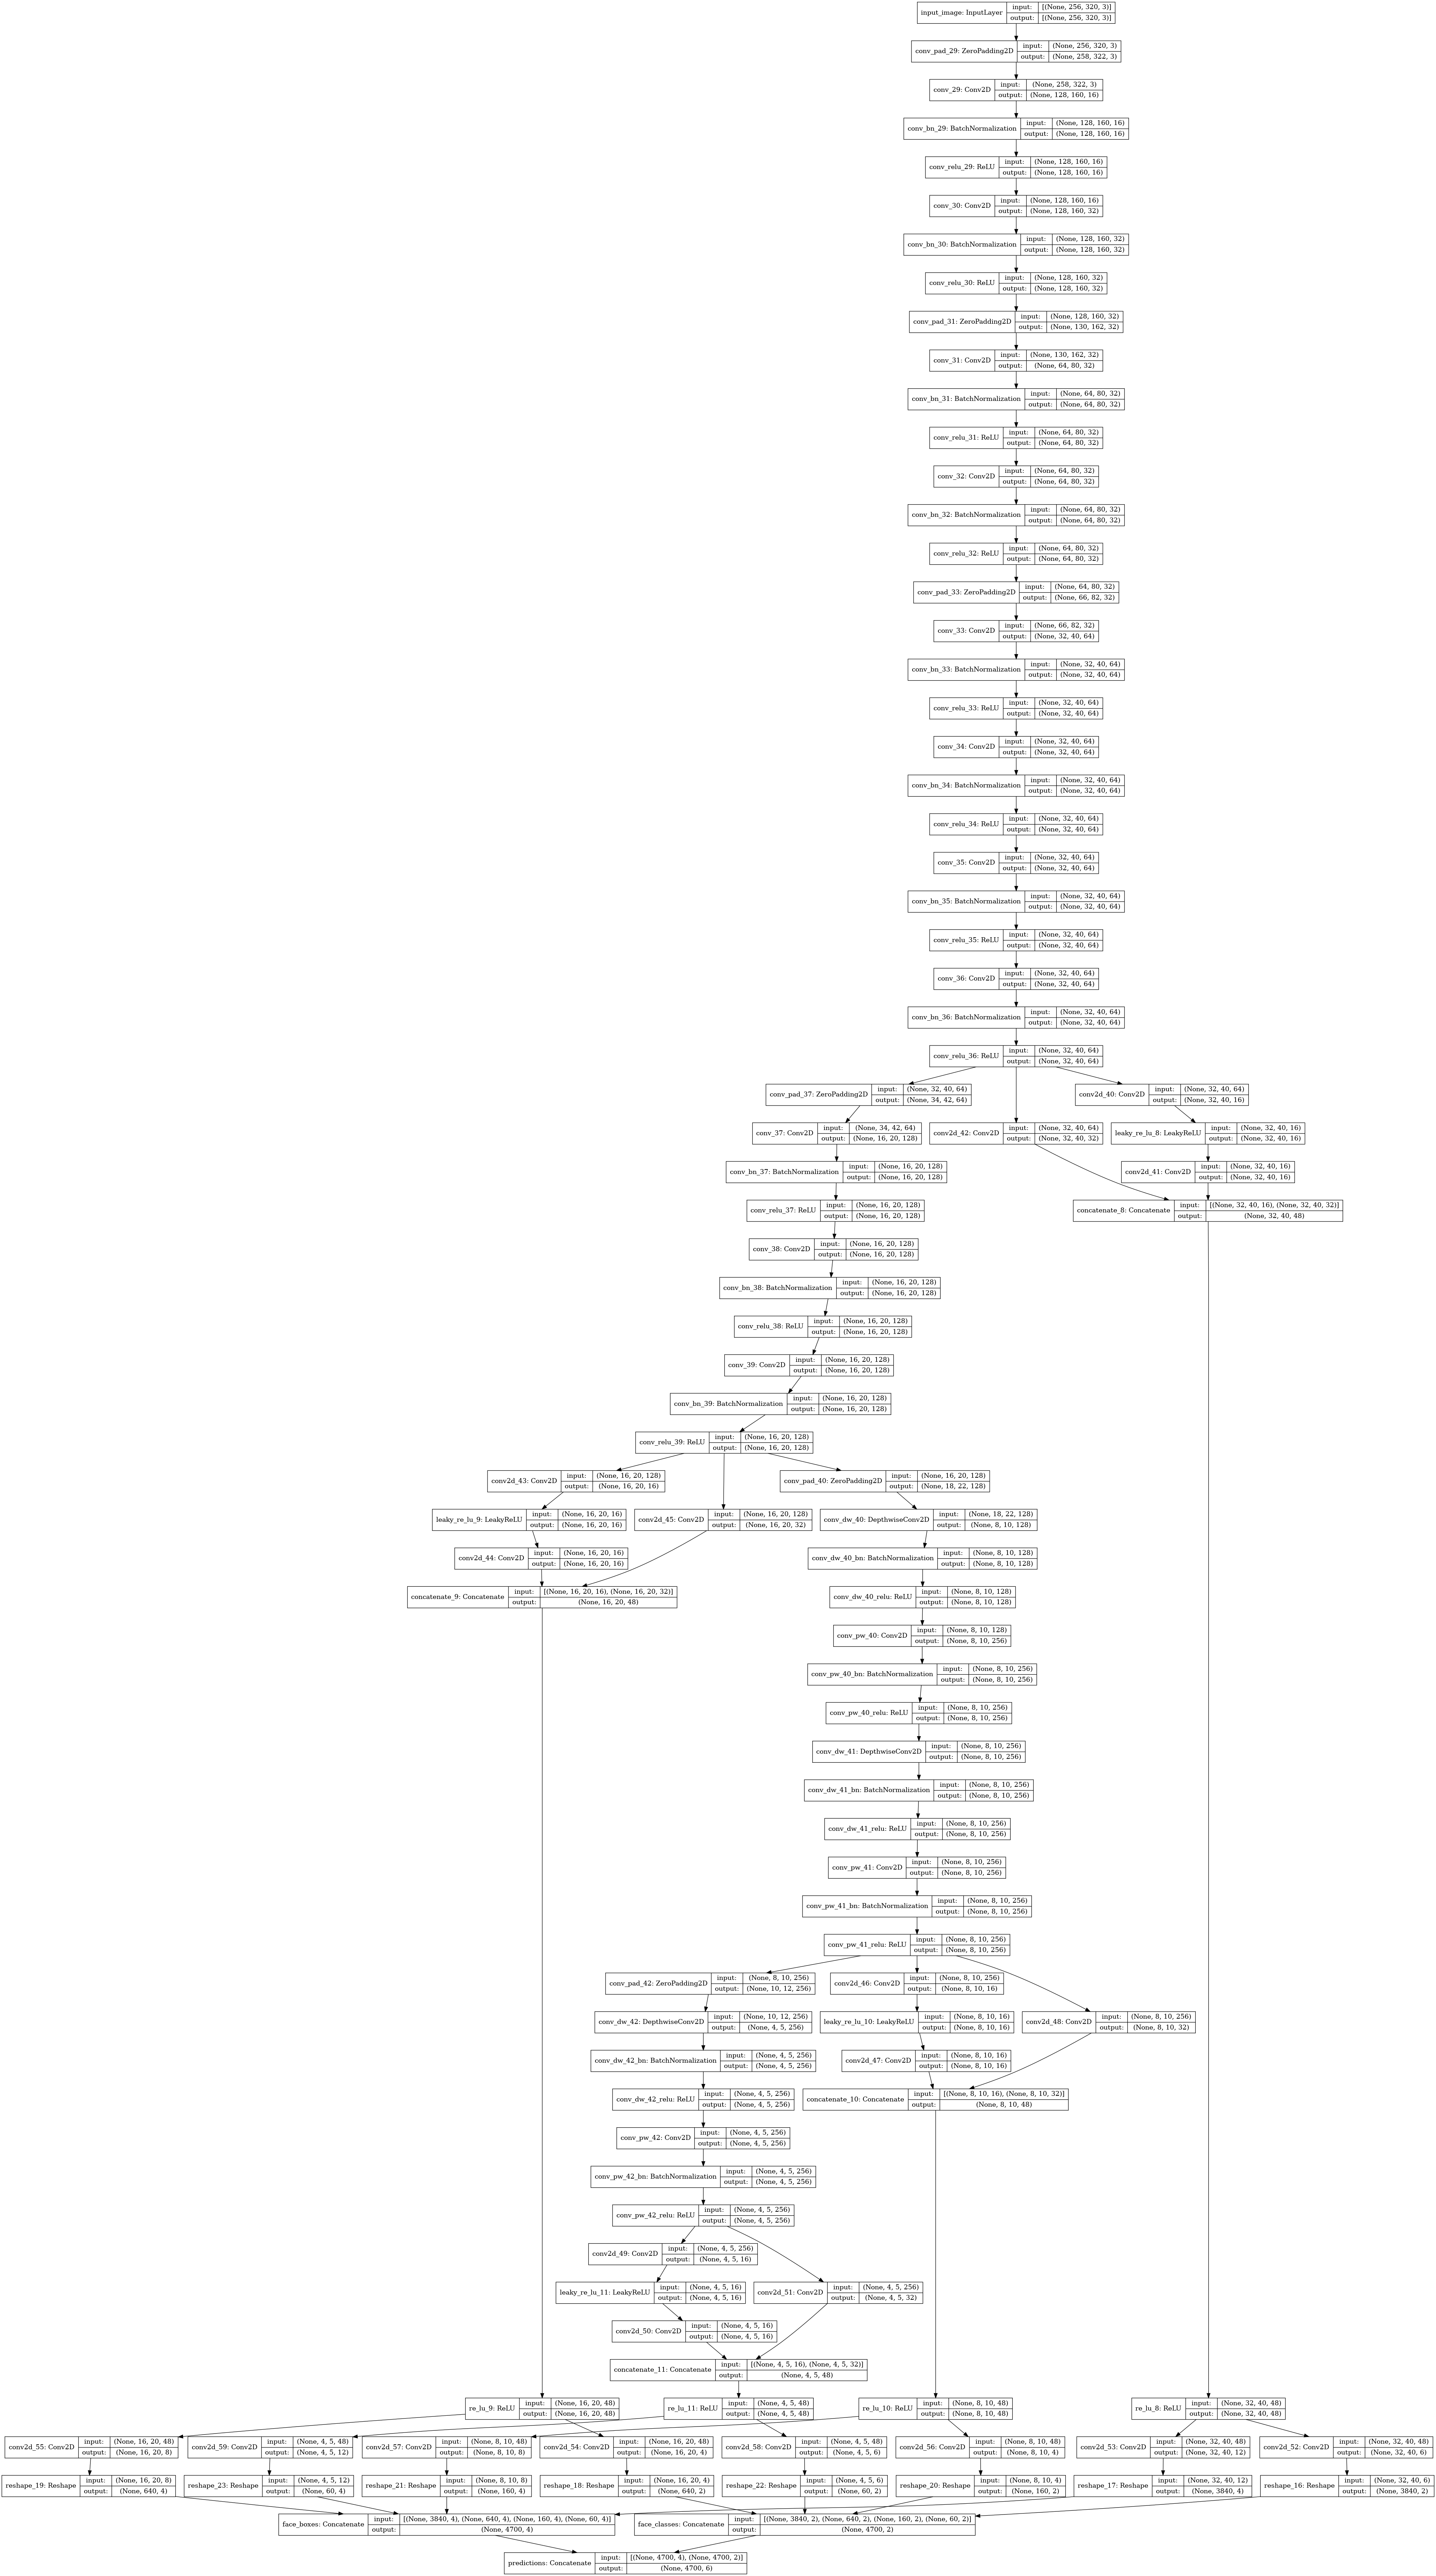

In [43]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [44]:
# @tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

print('슝=3')

슝=3


In [45]:
# 모델 및 히스토리 저장 경로
MODEL_SAVE_PATH = "saved_model/my_ssd_model"
BEST_MODEL_PATH = "saved_model/best_model_checkpoint.h5"
HISTORY_SAVE_PATH = "history.txt"


# 저장된 모델 불러오기
def load_model(model_path):
    if os.path.exists(model_path):
        print(f"모델을 {model_path}에서 불러옵니다...")
        loaded_model = tf.keras.models.load_model(model_path)
        print("모델이 성공적으로 불러와졌습니다.")
        return loaded_model
    else:
        raise FileNotFoundError(f"모델 경로 {model_path}이(가) 존재하지 않습니다.")

model = load_model(BEST_MODEL_PATH)        

모델을 saved_model/best_model_checkpoint.h5에서 불러옵니다...
모델이 성공적으로 불러와졌습니다.


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint



# ModelCheckpoint로 최적 모델 자동 저장
model_checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor='total_loss',  # 'total_loss'를 기준으로 최적 모델 저장
    save_best_only=True,
    mode='min',  # 손실이 작아질수록 좋은 모델로 판단
    verbose=1
)




print('슝=3')

슝=3


In [47]:
import os
import time
import json
from tensorflow.keras.callbacks import ModelCheckpoint

BEST_LOSS_PATH = "saved_model/best_loss.json"



# 손실 저장용 리스트
history = {
    "total_loss": [],
    "loc_loss": [],
    "class_loss": [],
    "epoch_loss": [],       # 에포크별 총 손실
    "avg_epoch_loss": []    # 에포크별 평균 손실
}

# 최적 손실값 초기화 또는 로드
'''
기존에 학습 된 최적의 모델을 불러와서 학습하는 경우 
초기 학습에서 지난학습의 best_loss보다 높은값을 가진 모델이 
best model로 저장되는 상활 발생
아래의 코드로 best_loss 함께 가져와 학습하도록 수정함
'''

if os.path.exists(BEST_LOSS_PATH):
    try:
        with open(BEST_LOSS_PATH, "r") as f:
            content = f.read().strip()  # 파일 내용을 읽고 공백 제거
            if content:  # 파일이 비어 있지 않은 경우
                best_loss = json.loads(content).get("best_loss", float('inf'))
            else:
                best_loss = float('inf')  # 파일이 비어 있으면 기본값
    except (json.JSONDecodeError, ValueError):
        print(f"{BEST_LOSS_PATH} 파일이 유효하지 않습니다. 기본값으로 초기화합니다.")
        best_loss = float('inf')
else:
    best_loss = float('inf')  # 파일이 없을 경우 기본값 설정



# steps_per_epoch = DATASET_LEN // BATCH_SIZE
# learning_rate = MultiStepWarmUpLR(
#     initial_learning_rate=1e-2,
#     lr_steps=[e * steps_per_epoch for e in [50, 70]],
#     lr_rate=0.1,
#     warmup_steps=5 * steps_per_epoch,
#     min_lr=1e-4
# )
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
# multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

# 학습 설정
steps_per_epoch = DATASET_LEN // BATCH_SIZE

# MultiStepWarmUpLR 학습률 스케줄 설정(예시)
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-3,                      # 초기 학습률 1e-2에서 1e-3으로 낮춤
    lr_steps=[e * steps_per_epoch for e in [50, 70, 90]],  # 추가 milestone(90) 설정
    lr_rate=0.1,
    warmup_steps=10 * steps_per_epoch,               # 기존 5배에서 10배로 늘림
    min_lr=1e-5                                      # 최저 학습률을 1e-5로 설정
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum=0.9,
    nesterov=True
)


multi_loss = MultiBoxLoss(
    len(IMAGE_LABELS),
    neg_pos_ratio=3  # 필요시 더 큰 값(5 이상)으로 조정 가능
)



# 모델 컴파일
model.compile(
    optimizer=optimizer,   # 옵티마이저 설정
    loss=multi_loss        # 손실 함수 설정
)

# Epoch 설정
EPOCHS = 1 #기존 모델 로드
steps_per_epoch = DATASET_LEN // BATCH_SIZE  # 데이터셋 크기와 배치 크기로 계산

# 학습 루프
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS} 시작...")
    epoch_loss = 0.0  # 에포크 손실 초기화

    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        # 배치 시작 시간 기록
        load_t0 = time.time()

        # 모델 학습 단계
        total_loss, losses = train_step(inputs, labels)

        # 배치 종료 시간 기록
        load_t1 = time.time()
        batch_time = load_t1 - load_t0

        # 손실 저장
        history["total_loss"].append(total_loss.numpy())
        history["loc_loss"].append(losses['loc'].numpy())
        history["class_loss"].append(losses['class'].numpy())

        # 에포크 손실 누적
        epoch_loss += total_loss.numpy()

        # 진행 상황 출력
        print(
            f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} "
            f"| Batch time {batch_time:.3f}s || "
            f"Total Loss: {total_loss:.6f} | Loc Loss: {losses['loc']:.6f} | Class Loss: {losses['class']:.6f} ",
            end='', flush=True
        )

    # 평균 에포크 손실 계산
    avg_epoch_loss = epoch_loss / steps_per_epoch
    history["epoch_loss"].append(epoch_loss)           # 총 에포크 손실 저장
    history["avg_epoch_loss"].append(avg_epoch_loss)   # 평균 에포크 손실 저장

    # 에포크 종료 후 줄바꿈 및 평균 손실 출력
    print(f"\nEpoch {epoch + 1}/{EPOCHS} Average Loss: {avg_epoch_loss:.6f}")

    # 모델 저장
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    model.save(MODEL_SAVE_PATH, include_optimizer=False)
    print(f"모델이 {MODEL_SAVE_PATH}에 저장되었습니다.")

    # 최적 모델 저장
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        model.save(BEST_MODEL_PATH, include_optimizer=False)
        print(f"최적 모델이 {BEST_MODEL_PATH}에 저장되었습니다 (Loss: {best_loss:.6f}).")
        
        # 최적 손실값 저장
        with open(BEST_LOSS_PATH, "w") as f:
            json.dump({"best_loss": best_loss}, f)


# ModelCheckpoint로 최적 모델 자동 저장
model_checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor='avg_epoch_loss',  # 'avg_epoch_loss'를 기준으로 최적 모델 저장
    save_best_only=True,
    mode='min',  # 손실이 작아질수록 좋은 모델로 판단
    verbose=1
)
model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[model_checkpoint]
)

# 히스토리 저장
with open(HISTORY_SAVE_PATH, "w") as f:
    for total, loc, cls, epoch, avg_epoch in zip(
        history["total_loss"], history["loc_loss"], history["class_loss"], 
        history["epoch_loss"], history["avg_epoch_loss"]
    ):
        f.write(f"Total Loss: {total:.6f}, Loc Loss: {loc:.6f}, Class Loss: {cls:.6f}, "
                f"Epoch Loss: {epoch:.6f}, Avg Epoch Loss: {avg_epoch:.6f}\n")
print(f"히스토리가 {HISTORY_SAVE_PATH}에 저장되었습니다.")


Epoch 1/1 시작...
Epoch: 1/1 | Batch 402/402 | Batch time 0.371s || Total Loss: 5.306640 | Loc Loss: 4.065029 | Class Loss: 1.241611 
Epoch 1/1 Average Loss: 4.518281
INFO:tensorflow:Assets written to: saved_model/my_ssd_model/assets
모델이 saved_model/my_ssd_model에 저장되었습니다.
402/402 [==============================] - 130s 318ms/step - loss: 2.2219
히스토리가 history.txt에 저장되었습니다.


손실 그래프가 'loss_plot.png'로 저장되었습니다.


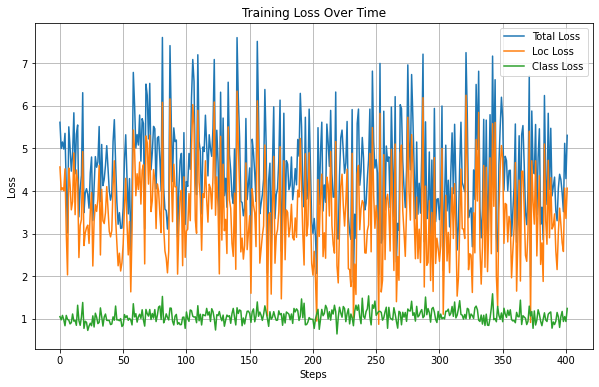

In [50]:
import matplotlib.pyplot as plt


# 학습 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history["total_loss"], label="Total Loss")
plt.plot(history["loc_loss"], label="Loc Loss")
plt.plot(history["class_loss"], label="Class Loss")
plt.title("Training Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
print("손실 그래프가 'loss_plot.png'로 저장되었습니다.")
plt.show()

## NMS 구현하기
--- 

Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요합니다. 아래 코드를 확인해 주세요.

In [51]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

print('슝=3')

슝=3


NMS를 통해 겹쳐진 box를 하나로 줄일 수 있게 되었다면, 이제 모델의 예측 결과를 해석해주는 함수를 작성합니다.

아래 함수에서는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 줍니다.

In [52]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

print('슝=3')

슝=3


In [66]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.60 # 0.5일 때 이상 바운딩 박스 생성 아래 사진 참고

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

print('슝=3')

슝=3


#### cls_scores > 0.5(0.6 변경 후 사라짐)

score_idx = cls_scores > 0.6 값을 변경하면서 작은 바운딩 박스가 사라진 이유는 
**Confidence Score(신뢰 점수)**의 임계값을 높임으로써 잘못된 검출(즉, False Positive)이 필터링 됨.

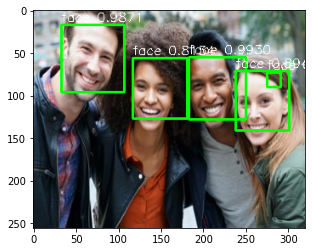



* 참고

Confidence Score(신뢰 점수):

모델은 각 바운딩 박스마다 각 클래스에 대해 신뢰 점수를 할당합니다.
작은 바운딩 박스나 잘못된 바운딩 박스는 일반적으로 낮은 신뢰 점수를 가지며, 낮은 임계값(예: 0.5)에서 이러한 박스가 포함될 수 있습니다.


Threshold(임계값) 변화:

score_idx = cls_scores > 0.6로 임계값을 증가시키면서, 신뢰 점수가 0.6보다 낮은 바운딩 박스가 필터링되었습니다.
잘못된 검출(예: 작거나 이상한 위치의 바운딩 박스)이 주로 신뢰 점수가 낮기 때문에, 임계값을 높이면 이런 박스가 제거됩니다.


NMS(Non-Maximum Suppression)와의 관계:

NMS는 기본적으로 높은 신뢰 점수와 IoU를 기반으로 바운딩 박스를 선택합니다.
신뢰 점수가 낮은 박스는 NMS로 인해 더 큰 신뢰 점수를 가진 박스에 의해 제거될 가능성이 있습니다.
하지만 낮은 임계값을 설정하면 NMS 이전에 필터링되지 않은 잘못된 박스가 NMS 과정으로 전달될 수 있습니다.

In [54]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

print('슝=3')

슝=3


In [55]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

print('슝=3')

슝=3


In [56]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

print('슝=3')

슝=3


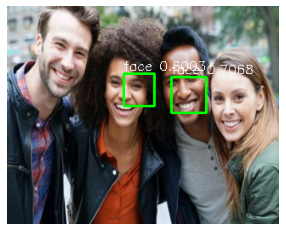

In [57]:
#기존 제공 모델 가중가 가져와서 비교

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 저장된 모델 경로
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')

# 모델 가중치 로드
model.load_weights(filepath)

# 테스트 이미지 경로
TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

# 테스트 이미지 읽기
img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

# BGR -> RGB로 변환
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 입력 이미지를 패딩
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))

# 정규화 (0~1 사이로 스케일링)
img = img / 255.0

# 기본 박스 생성
boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

# 예측 수행
predictions = model.predict(img[np.newaxis, ...])

# 예측 결과 파싱
pred_boxes, labels, scores = parse_predict(predictions, boxes)

# 패딩 복구
pred_boxes = recover_pad(pred_boxes, pad_params)

# 결과 이미지에 바운딩 박스 그리기
for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

# 이미지 출력
plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 축 제거
plt.show()


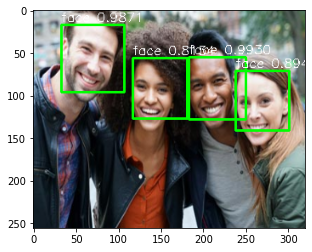

In [58]:
# filepath = os.path.join(MODEL_SAVE_PATH, 'checkpoints', 'weights_epoch_008.h5')
model.load_weights(BEST_MODEL_PATH) # filepath

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

In [59]:
# 왕관 스티커 path 설정
whisker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/king2.png'
whisker_img = cv2.imread(whisker_path, cv2.IMREAD_UNCHANGED)

# 이미지 로드 실패 확인
if whisker_img is None:
    raise FileNotFoundError(f"이미지를 로드할 수 없습니다: {whisker_img_path}")
    
    
# 채널 수 확인
if whisker_img.shape[-1] == 4:  # 알파 채널이 있는 경우
    whisker_alpha = whisker_img[:, :, 3] / 255.0  # 알파 채널 분리
    whisker_rgb = whisker_img[:, :, :3]           # RGB 채널 분리
elif whisker_img.shape[-1] == 3:  # RGB 이미지인 경우
    whisker_alpha = np.ones(whisker_img.shape[:2], dtype=np.float32)  # 알파 채널을 기본값(1.0)으로 설정
    whisker_rgb = whisker_img  # RGB 채널 그대로 사용
else:
    raise ValueError("지원하지 않는 이미지 형식입니다. RGBA 또는 RGB 이미지를 사용하세요.")

# 출력 확인
print(f"RGB 채널 크기: {whisker_rgb.shape}")
print(f"알파 채널 크기: {whisker_alpha.shape}") 

RGB 채널 크기: (512, 512, 3)
알파 채널 크기: (512, 512)


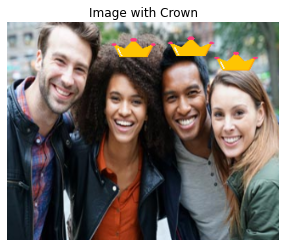

In [60]:

import cv2



# 왕관 오버레이 함수
def overlay_crown(img_raw, pred_boxes, crown_img, labels, scores, class_list):
    """
    얼굴 바운딩 박스 상단에 왕관 스티커를 오버레이합니다.
    """
    img_with_crown = img_raw.copy()

    for box_index in range(len(pred_boxes)):
        # 바운딩 박스 좌표 계산
        x_min = int(pred_boxes[box_index][0] * img_raw.shape[1])
        y_min = int(pred_boxes[box_index][1] * img_raw.shape[0])
        x_max = int(pred_boxes[box_index][2] * img_raw.shape[1])
        y_max = int(pred_boxes[box_index][3] * img_raw.shape[0])

        # 특정 클래스에 대해 왕관 추가 (예: class ID == 1)
        if labels[box_index] == 1:
            # 왕관 크기 설정
            crown_width = x_max - x_min
            crown_height = crown_width // 2  # 왕관 높이는 너비의 절반

            # 왕관 중심 좌표 계산 (바운딩 박스 상단에서 10픽셀 위)
            crown_x = (x_min + x_max) // 2
            crown_y = y_min - 10

            # 왕관 스티커 크기 조정
            resized_crown = cv2.resize(crown_img, (crown_width, crown_height))

            # 왕관 적용 영역 설정
            x1 = crown_x - crown_width // 2
            y1 = crown_y - crown_height
            x2 = x1 + crown_width
            y2 = y1 + crown_height

            # 이미지 경계 확인
            if x1 >= 0 and y1 >= 0 and x2 <= img_with_crown.shape[1] and y2 <= img_with_crown.shape[0]:
                # 왕관 스티커의 알파 채널 분리
                crown_alpha = resized_crown[:, :, 3] / 255.0
                crown_rgb = resized_crown[:, :, :3]

                # ROI 영역에 왕관 스티커 합성
                roi = img_with_crown[y1:y2, x1:x2]
                for c in range(3):  # BGR 채널별 합성
                    roi[:, :, c] = (1.0 - crown_alpha) * roi[:, :, c] + crown_alpha * crown_rgb[:, :, c]

                # 결과 적용
                img_with_crown[y1:y2, x1:x2] = roi

    return img_with_crown


# 모델 로드
#model = tf.keras.models.load_model(BEST_MODEL_PATH)
model.load_weights(BEST_MODEL_PATH)

# 테스트 이미지 로드 및 전처리
img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

# BGR -> RGB 변환
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 입력 이미지를 패딩
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))

# 정규화
img = img / 255.0

# 기본 박스 생성 및 예측
boxes = default_box()
boxes = tf.cast(boxes, tf.float32)
predictions = model.predict(img[np.newaxis, ...])

# 예측 결과 파싱
pred_boxes, labels, scores = parse_predict(predictions, boxes)

# 패딩 복구
pred_boxes = recover_pad(pred_boxes, pad_params)

# 왕관 스티커 이미지 로드 (RGBA 형식)

img_sticker = cv2.imread(whisker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다


# 왕관을 오버레이한 이미지 생성
img_with_crown = overlay_crown(img_raw, pred_boxes, img_sticker, labels, scores, IMAGE_LABELS)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_with_crown, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image with Crown")
plt.show()





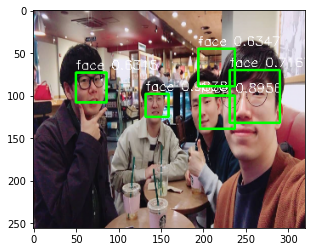

In [67]:

my_image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image.png'


# filepath = os.path.join(MODEL_SAVE_PATH, 'checkpoints', 'weights_epoch_008.h5')
model.load_weights(BEST_MODEL_PATH) # filepath



img_raw = cv2.imread(my_image_path)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

탐지된 얼굴 수:

이미지에서 총 5개의 얼굴이 탐지되었습니다.
바운딩 박스와 신뢰 점수:

각 바운딩 박스에는 라벨과 신뢰 점수가 표시됩니다. 신뢰 점수는 다음과 같습니다:

얼굴 1: 0.6315 (좌측 상단)

얼굴 2: 0.7416 (중앙 좌측)

얼굴 3: 0.8956 (중앙)

얼굴 4: 0.8069 (중앙 우측)

얼굴 5: 0.6347 (우측 상단, 오검출)

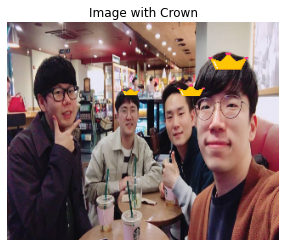

In [65]:

import cv2



# 왕관 오버레이 함수
def overlay_crown(img_raw, pred_boxes, crown_img, labels, scores, class_list):
    """
    얼굴 바운딩 박스 상단에 왕관 스티커를 오버레이합니다.
    """
    img_with_crown = img_raw.copy()

    for box_index in range(len(pred_boxes)):
        # 바운딩 박스 좌표 계산
        x_min = int(pred_boxes[box_index][0] * img_raw.shape[1])
        y_min = int(pred_boxes[box_index][1] * img_raw.shape[0])
        x_max = int(pred_boxes[box_index][2] * img_raw.shape[1])
        y_max = int(pred_boxes[box_index][3] * img_raw.shape[0])

        # 특정 클래스에 대해 왕관 추가 (예: class ID == 1)
        if labels[box_index] == 1:
            # 왕관 크기 설정
            crown_width = x_max - x_min
            crown_height = crown_width // 2  # 왕관 높이는 너비의 절반

            # 왕관 중심 좌표 계산 (바운딩 박스 상단에서 10픽셀 위)
            crown_x = (x_min + x_max) // 2
            crown_y = y_min - 10

            # 왕관 스티커 크기 조정
            resized_crown = cv2.resize(crown_img, (crown_width, crown_height))

            # 왕관 적용 영역 설정
            x1 = crown_x - crown_width // 2
            y1 = crown_y - crown_height
            x2 = x1 + crown_width
            y2 = y1 + crown_height

            # 이미지 경계 확인
            if x1 >= 0 and y1 >= 0 and x2 <= img_with_crown.shape[1] and y2 <= img_with_crown.shape[0]:
                # 왕관 스티커의 알파 채널 분리
                crown_alpha = resized_crown[:, :, 3] / 255.0
                crown_rgb = resized_crown[:, :, :3]

                # ROI 영역에 왕관 스티커 합성
                roi = img_with_crown[y1:y2, x1:x2]
                for c in range(3):  # BGR 채널별 합성
                    roi[:, :, c] = (1.0 - crown_alpha) * roi[:, :, c] + crown_alpha * crown_rgb[:, :, c]

                # 결과 적용
                img_with_crown[y1:y2, x1:x2] = roi

    return img_with_crown


# 모델 로드
#model = tf.keras.models.load_model(BEST_MODEL_PATH)
model.load_weights(BEST_MODEL_PATH)

# 테스트 이미지 로드 및 전처리
img_raw = cv2.imread(my_image_path)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

# BGR -> RGB 변환
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 입력 이미지를 패딩
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))

# 정규화
img = img / 255.0

# 기본 박스 생성 및 예측
boxes = default_box()
boxes = tf.cast(boxes, tf.float32)
predictions = model.predict(img[np.newaxis, ...])

# 예측 결과 파싱
pred_boxes, labels, scores = parse_predict(predictions, boxes)

# 패딩 복구
pred_boxes = recover_pad(pred_boxes, pad_params)

# 왕관 스티커 이미지 로드 (RGBA 형식)

img_sticker = cv2.imread(whisker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다


# 왕관을 오버레이한 이미지 생성
img_with_crown = overlay_crown(img_raw, pred_boxes, img_sticker, labels, scores, IMAGE_LABELS)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_with_crown, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image with Crown")
plt.show()





### 회고
- 시간의 한계로 다양한 실험을 해보지 못한것이 아쉽다.
-  SSD모델을 학슬하여 face detectin 성능을 끌어 올렸다.
- 성능은 개선 되었으나, 훈련 데이터셋의 영향인지 기존 사진 데이터는 잘 인식하지 못하였다.
- 자세한 부분은 추가 실험이 필요할 듯하다.